## Requirements

In [ ]:
import sys
if (sys.version_info.major, sys.version_info.minor) == (3, 7):
    print(f"Python version OK")
else:
    print("Incorrect Python version, must be 3.7")

In [ ]:
import os

def check_module(module, install=True, upgrade=True):
    try:
        __import__(module)
        print(f"Module '{module}' OK")
        if upgrade:
            print(f"Upgrading '{module}'...")
            print(os.popen(f"pip install --user -U {module.replace('_', '-')}").read())
        
    except ModuleNotFoundError:
        print(f"Module '{module}' not found")
        if install:
            print(f"Installing '{module}'......")
            print(os.popen(f"pip install --user {module.replace('_', '-')}").read())
            print('Installed')
            check_module(module)

- Modules to install

In [ ]:
modules = [
    'struct',
    'numpy',
    'time',
    'atexit',
    'logging',
    'sys',
    'glob',
    'PyQt5',
    'scipy',
    'seaborn',
    'matplotlib',
    'pyqtgraph',
]

[check_module(module) for module in modules];

## Connection and acquisition

- Board connection

In [1]:
import open_bci as bci
import time as tm
import numpy as np
import struct
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
from numpy import matlib
import seaborn as sns

baud = 115200
board = bci.OpenBCIBoard(port=None, baud = baud, filter_data = True)
print("EEG Channels :",board.eeg_channels_per_sample)
print("Aux Channels :",board.aux_channels_per_sample)



Searching Board...
Serial established...
OpenBCI V3 8-16 channel
On Board ADS1299 Device ID: 0x3E
LIS3DH Device ID: 0x33
Firmware: v3.1.1
$$$
Connecting to V3 at port /dev/ttyUSB0
EEG Channels : 8
Aux Channels : 3


- Parameters for acquisition

In [2]:
fs = 250.0                     # Sample Frequency
START_BYTE = 0xA0               
END_BYTE = 0xC0                 
TIME = 4                       #Seconds to read
Adquic = int(TIME*fs)          #Samples to read
eeg_raw = []                   #Save raw data

- Stream mode activated

In [3]:
board.ser.write(b'b')
board.streaming = True

- Good reading of data

In [4]:
def read(n):
    b = board.ser.read(n)
    if not b:
        board.warn('Device appears to be stalled. Quitting...')
        sys.exit()
        raise Exception('Device Stalled')
        sys.exit()
        return '\xFF'
    else:
        return b
    

Read_state:
- 0 means that is looking for the start byte
- 1 means that is acquiring data from EEG channels.
- 2 means that is acquiring accelerometer data.
- 3 means that is looking for the end byte

In [5]:
max_bytes_to_skip=10000
board.read_state = 0

def read_data(board, max_bytes_to_skip):
    for rep in range(max_bytes_to_skip):
        
        if board.read_state == 0:
            b = read(1)
            
            if struct.unpack('B', b)[0] == START_BYTE:
                #print("START BYTE FOUND: ",b)
                if(rep != 0):
                    #board.warn('Skipped %d bytes before start found' %(rep))
                    rep = 0;
                packet_id = struct.unpack('B', read(1))[0] 
                #print("PACKET_ID: ",packet_id)
                board.read_state = 1

        elif board.read_state == 1:
            channel_data = []
            #print("Obtaining data from EEG Channels...")
            for c in range(board.eeg_channels_per_sample):

                literal_read = read(3)

                unpacked = struct.unpack('3B', literal_read)

                
                if (unpacked[0] > 127):
                    pre_fix = bytes(bytearray.fromhex('FF')) 
                else:
                    pre_fix = bytes(bytearray.fromhex('00'))


                literal_read = pre_fix + literal_read;

                
                myInt = struct.unpack('>i', literal_read)[0]
                #print("CH"+str(c)+"= ", myInt)
                channel_data.append(myInt)
                
                board.read_state = 2;

          #---------Accelerometer Data---------
        elif board.read_state == 2:
            aux_data = []
            for a in range(board.aux_channels_per_sample):

                # short = h
                acc = struct.unpack('>h', read(2))[0]
                aux_data.append(acc)

            board.read_state = 3;

        #---------End Byte---------
        elif board.read_state == 3:
            val = struct.unpack('B', read(1))[0]
            board.read_state = 0 
            if (val == END_BYTE):
                #print("END BYTE FOUND: ",END_BYTE)
                sample = bci.OpenBCISample(packet_id, channel_data, aux_data)
                board.packets_dropped = 0
               
                return sample
            else:
                board.packets_dropped = board.packets_dropped + 1


 - Data acquisition

In [6]:
print("Acquiring EEG data...")
for seconds in range(Adquic):
    sample = read_data(board,max_bytes_to_skip)
    eeg_raw.append(sample.channel_data)
eeg_raw = np.transpose(np.asarray(eeg_raw))
print("Channels: ", eeg_raw.shape[0])
print("Samples: ", eeg_raw.shape[1])

Acquiring EEG data...
Channels:  8
Samples:  1000


- Scaling and centering

In [7]:
[fil,col] = eeg_raw.shape
for i in range(fil):
    data = eeg_raw[i,:] * 2.23517444553071e-02
    eeg_raw[i,:] = eeg_raw[i,:] - np.mean(eeg_raw[i,:])

- Filtering and visualization

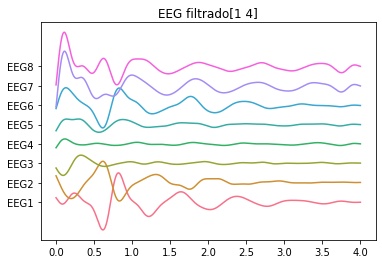

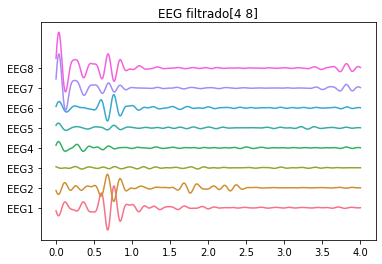

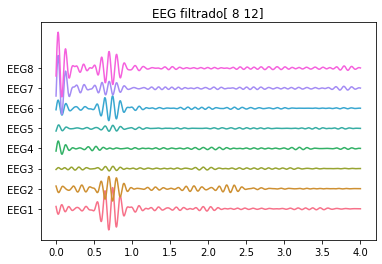

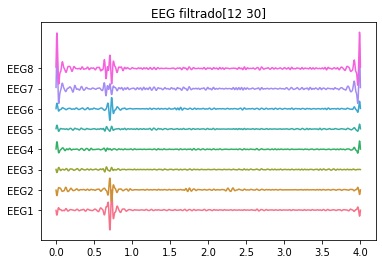

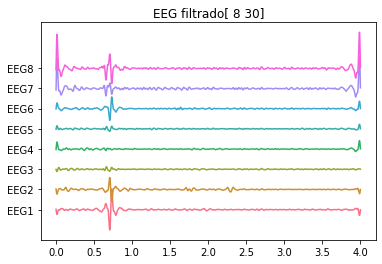

In [8]:
channels_names = ["EEG1","EEG2","EEG3","EEG4","EEG5","EEG6","EEG7","EEG8"]
channels,T = eeg_raw.shape
f_frec = np.array([[1,4],[4,8],[8,12],[12,30],[8,30]])
nf,ff = f_frec.shape
nyq = 0.5 * fs
order = 5
eeg_raw_f = np.zeros((channels,T,nf))

for f in range(nf):
    lfc = f_frec[f,0]
    hfc = f_frec[f,1]            
    low = lfc / nyq
    high = hfc / nyq
    b, a = butter(order, [low, high], btype='band')              
    eeg_raw_f[:,:,f] = filtfilt(b,a,eeg_raw,axis=1) 


for f in range(nf):
    data = eeg_raw_f[:,:,f]  
    plt.figure(f)
    plt.title('EEG filtrado'+str(f_frec[f])) 
    sca=0.75    
    time = np.linspace(0, data.shape[1] / fs, data.shape[1])
    fig = plt.gcf()
    sumf = sca*np.max(sca*(data-matlib.repmat(data.mean(axis=1).reshape(-1,1),1,data.shape[1])))
    plt.yticks(np.arange(0, sumf*len(channels_names),sumf),channels_names)
    color = sns.color_palette('husl',n_colors=data.shape[0])
    for i in range(data.shape[0]): 
        plt.plot(time, (data[i,:] - data[i,:].mean()) + sumf*i,color=color[i])

## GUIs 

#### GUI-RECORD:
Connection, acquisition, filtering, visualization and EEG data storage in a csv file

In [ ]:
%run -i 'GUI_Record.py'

#### GUI-REPLAY:
Filtering and visualization of EEG data read from a csv file

In [ ]:
%run -i 'GUI_Replay.py'